# Week 8

# *Demonstrate Convolutional Neural Network with various Convolution functions and Pooling functions*. 

Convolution variants

- Standard Conv2D — regular learned kernels. Use as default.

- Depthwise Separable Conv (Depthwise + Pointwise 1×1) — far fewer params, used in mobile nets.

- Grouped Convolution — split channels into groups; trade accuracy vs compute (ResNeXt uses this).

- Dilated (Atrous) Convolution — increases receptive field without more params (segmentation).

- Transposed Convolution — used for upsampling (generative models / decoders).

- Conv with stride >1 — downsamples directly via stride (alternative to pooling).

Pooling variants

- MaxPooling2D — keeps strongest activation (most common).

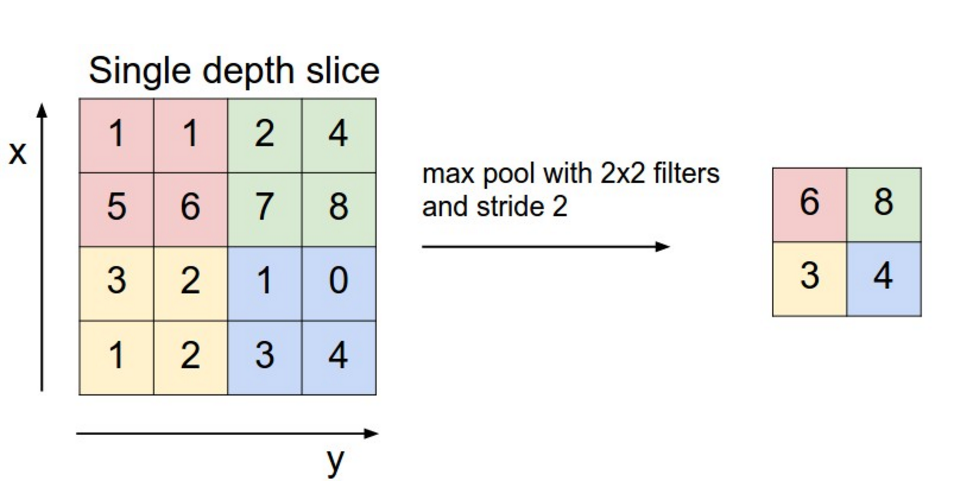

- AveragePooling2D — smooths activations (used sometimes in classification heads).
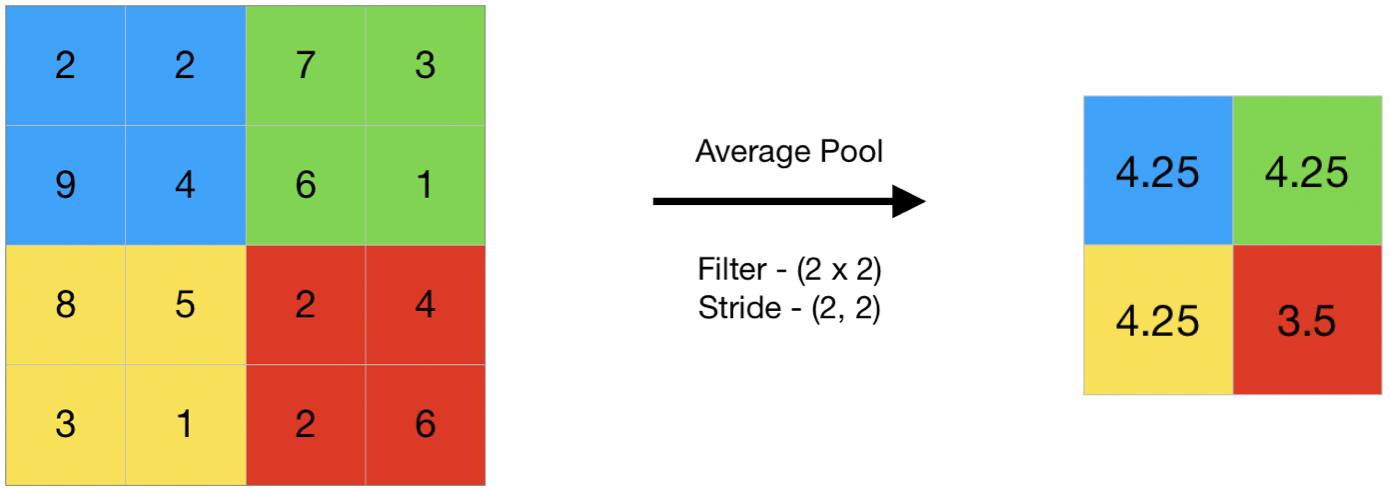

- GlobalMax/AvgPooling — aggregate whole feature map to vector (classification).
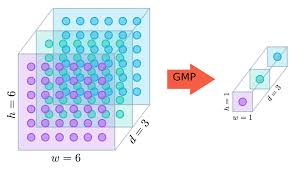

- LpPooling — generalization of average/max (rare).

- Stochastic pooling — randomly sample proportional to activation (research).
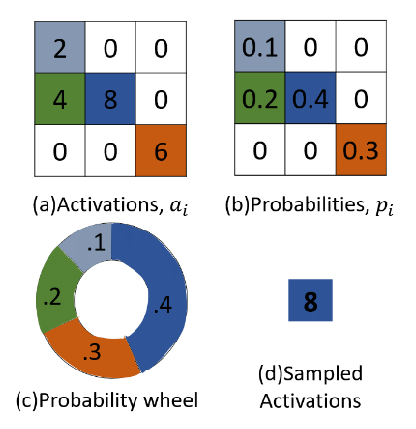

- Adaptive pooling (PyTorch) — output a fixed spatial size independent of input

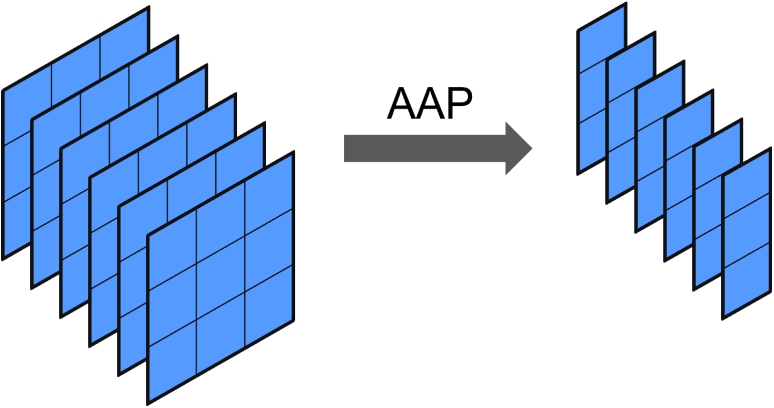

In [1]:
# Save as cnn_variants_keras.py
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

def conv_block(inputs, conv_type='standard', filters=32, kernel_size=3, stride=1, dilation=1, groups=1):
    if conv_type == 'standard':
        x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(inputs)
    elif conv_type == 'depthwise_sep':
        x = layers.SeparableConv2D(filters, kernel_size, padding='same', use_bias=False)(inputs)
    elif conv_type == 'dilated':
        x = layers.Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation, use_bias=False)(inputs)
    elif conv_type == 'grouped':
        # Keras doesn't have grouped conv in layer directly prior to TF 2.4; emulate via channel split or use groups arg if available
        try:
            x = layers.Conv2D(filters, kernel_size, padding='same', groups=groups, use_bias=False)(inputs)
        except Exception:
            # fallback: use depthwise as crude emulation
            x = layers.SeparableConv2D(filters, kernel_size, padding='same', use_bias=False)(inputs)
    elif conv_type == 'transpose':
        x = layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same', use_bias=False)(inputs)
    else:
        raise ValueError('unknown conv_type')
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def get_model(conv_type='standard', pool_type='max'):
    inp = layers.Input(shape=(32,32,3))
    x = conv_block(inp, conv_type=conv_type, filters=32)
    if pool_type == 'max':
        x = layers.MaxPool2D()(x)
    elif pool_type == 'avg':
        x = layers.AveragePooling2D()(x)
    elif pool_type == 'global_avg':
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.MaxPool2D()(x)
    x = conv_block(x if pool_type!='global_avg' else layers.Reshape((1,1,32))(x), conv_type=conv_type, filters=64)
    if pool_type != 'global_avg':
        x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(10)(x)
    model = models.Model(inp, x)
    return model

if __name__ == "__main__":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32')/255.0
    y_train = tf.keras.utils.to_categorical(y_train, 10)

    conv_type = 'depthwise_sep'  # try 'standard','depthwise_sep','dilated','grouped','transpose'
    pool_type = 'max'            # 'max','avg','global_avg'
    model = get_model(conv_type, pool_type)
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.summary()
    model.fit(x_train[:10000], y_train[:10000], batch_size=64, epochs=3)  # quick demo


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 32, 32, 32)     │           123 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 16, 16, 64)     │         2,336 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,493 (13.64 KB)

 Trainable params: 3,301 (12.89 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.1871 - loss: 2.1887
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.3026 - loss: 1.9348
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.3429 - loss: 1.8461


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


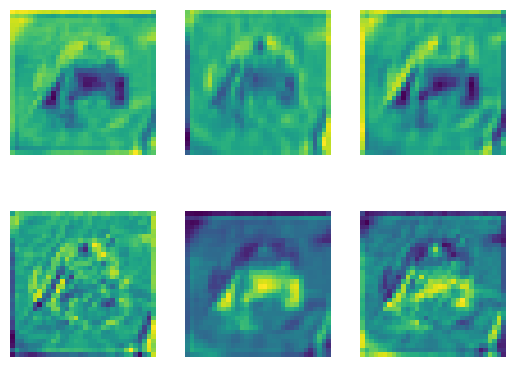

In [2]:
# get intermediate layer output
from tensorflow.keras.models import Model
layer_out = Model(inputs=model.input, outputs=model.layers[2].output)  # adjust index to conv layer
fm = layer_out.predict(x_train[:1])  # shape (1,H,W,C)
import matplotlib.pyplot as plt
for i in range(min(6, fm.shape[-1])):
    plt.subplot(2,3,i+1); plt.imshow(fm[0,:,:,i], cmap='viridis'); plt.axis('off')
plt.show()
